<a href="https://colab.research.google.com/github/chandlersutherland/beyond_the_genome/blob/master/Beyond_the_Genome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quick introduction to Google Colab

Google Colab is an interactive coding notebook that can be used to quickly and easily do some small tasks in Python, bash, or R. It's best feature is that it takes little to no installation and uses Google's cloud computing resources so it should be able to run on any computer.

Google colab lets you create two types of boxes in your document using the buttons with '+' in the top left corner: code boxes and text boxes. Text boxes like this one are great for explaining your code. Code boxes such as the one below can easily run code by clicking on the "play" button in the top right corner of each box.

The following bash command downloads the .fast5 files we will be converting into alignments from Github.


In [ ]:
!git clone https://github.com/chandlersutherland/beyond_the_genome.git

Cloning into 'beyond_the_genome'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 20 (delta 1), reused 8 (delta 0), pack-reused 10
Unpacking objects: 100% (20/20), 151.54 MiB | 9.47 MiB/s, done.
Updating files: 100% (10/10), done.


# Basecalling

Basecalling is the process of converting the electrical signals generated by a DNA strands passing through the nanopore into the corresponding nucleotide sequence. Guppy is Nanopore's basecalling software.

Basecallers convert raw signal data stored as .fast5 files to nucleotide sequences using algorithms that incorporate bi-directional **Recurrent Neural Networks** (RNNs). This is a type of machine learning algorithm. Neural networks receive and process data, but crucially, they have the ability to learn and improve their predictions for the output over time.

Guppy has learned the shape of the electrical signal of each nucleotide!

<img src='https://www.mdpi.com/sensors/sensors-22-02275/article_deploy/html/images/sensors-22-02275-g001.png'>

##Initiate GPU runtime ⏲
Nanopore basecalling requires graphical processing units, or GPUs, to convert the electrical signal of each base into a nucleotide. Google colab allows for GPU access, but we have to make sure it's correctly configured.



*   Go to the `Runtime` menu
*   Select the `Change runtime type` option
*   Make sure the `Hardware accelerator` is set to `GPU`



## Check the presence of a GPU
After setting the Runtime, you should be able to run the code block below. If successful, you should see something like `/device:GPU:0` as the output, meaning the GPU is available for use. If you recieve an error, or the GPU is 'Nvidia K80', please let me know.

In [ ]:
import tensorflow as tf
device_number = tf.test.gpu_device_name()

import torch
name_model = torch.cuda.get_device_name(0)

print('The device number is ' + device_number + ' and the name and model of the GPU is '+ name_model)

The device number is /device:GPU:0 and the name and model of the GPU is Tesla T4


## Download and Install Guppy 🐟



In [ ]:
#Download and unpack guppy, this will take about a minute
%%shell
wget https://cdn.oxfordnanoportal.com/software/analysis/ont-guppy_6.4.2_linux64.tar.gz
tar -xzvf ont-guppy_6.4.2_linux64.tar.gz

--2023-06-20 18:48:45--  https://cdn.oxfordnanoportal.com/software/analysis/ont-guppy_6.4.2_linux64.tar.gz
Resolving cdn.oxfordnanoportal.com (cdn.oxfordnanoportal.com)... 18.172.170.16, 18.172.170.74, 18.172.170.53, ...
Connecting to cdn.oxfordnanoportal.com (cdn.oxfordnanoportal.com)|18.172.170.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1669334522 (1.6G) [application/x-tar]
Saving to: ‘ont-guppy_6.4.2_linux64.tar.gz’

ont-guppy_6.4.2_lin 100%[===================>]   1.55G  27.6MB/s    in 66s     

2023-06-20 18:49:52 (24.1 MB/s) - ‘ont-guppy_6.4.2_linux64.tar.gz’ saved [1669334522/1669334522]

ont-guppy/bin/
ont-guppy/bin/autoconfigure_guppy_server.py
ont-guppy/bin/guppy_basecall_client
ont-guppy/bin/guppy_basecall_server
ont-guppy/bin/guppy_basecaller
ont-guppy/bin/guppy_basecaller_duplex
ont-guppy/bin/guppy_basecaller_supervisor
ont-guppy/data/
ont-guppy/data/YHR174W.fasta
ont-guppy/data/adapter_scaling_dna_r10.3_min.jsn
ont-guppy/data/adapter_scal

##Check the Guppy version
We should now be able to run all the files we downloaded. They are located in `/content/ont-guppy/bin/guppy_basecaller`. The below code block should run the basecaller and report the version of the software.

In [ ]:
%%shell
/content/ont-guppy/bin/guppy_basecaller --version

: Guppy Basecalling Software, (C) Oxford Nanopore Technologies plc. Version 6.4.2+97a7f06, minimap2 version 2.24-r1122

Use of this software is permitted solely under the terms of the end user license agreement (EULA).
By running, copying or accessing this software, you are demonstrating your acceptance of the EULA.
The EULA may be found in /content/ont-guppy/bin


## Run Basecalling
Now for the fun! First, we will set a few variables, including where our data is and where we want it to go. To save time, we are using the fast calling model, which sacrifices some accuracy but can be run quickly and with few computational resources. This step should generate several new folders and files, but what we care about is the "pass" folder containing our new .fastq files.

In [ ]:
%%shell
inputPath="/content/beyond_the_genome/fast5_files"
outputPath="/content/beyond_the_genome/fasta_files"
mkdir -p $outputPath
guppy_bc=/content/ont-guppy/bin/guppy_basecaller                               # set guppy_basecaller binary location
guppy_cfg_fast=/content/ont-guppy/data/dna_r9.4.1_450bps_fast.cfg              # fast model calling


$guppy_bc -i $inputPath -s $outputPath \
--recursive \
--config $guppy_cfg_fast \
--gpu_runners_per_device 16 \
--cpu_threads_per_caller 2 \
--device cuda:0

ONT Guppy basecalling software version 6.4.2+97a7f06, minimap2 version 2.24-r1122
config file:        /content/ont-guppy/data/dna_r9.4.1_450bps_fast.cfg
model file:         /content/ont-guppy/data/template_r9.4.1_450bps_fast.jsn
input path:         /content/beyond_the_genome/fast5_files
save path:          /content/beyond_the_genome/fasta_files
chunk size:         2000
chunks per runner:  160
minimum qscore:     8
records per file:   4000
num basecallers:    4
gpu device:         cuda:0
kernel path:        
runners per device: 16

Use of this software is permitted solely under the terms of the end user license agreement (EULA).
By running, copying or accessing this software, you are demonstrating your acceptance of the EULA.
The EULA may be found in /content/ont-guppy/bin
Found 9 input read files to process.
Init time: 784 ms

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Ca

## Investigate the output 👀
Let's take a look at one of the files we produced (.fastq files).

In [ ]:
%%shell
cd /content/beyond_the_genome/fasta_files/pass
head fastq_runid_26afa4cc17f032b296f29a45413367fe217634b2_0_0.fastq

@b8464039-be83-4a5a-a974-c934f296e297 runid=26afa4cc17f032b296f29a45413367fe217634b2 sampleid=S3 read=5144 ch=121 start_time=2021-11-09T18:49:37Z model_version_id=2021-05-17_dna_r9.4.1_minion_96_29d8704b
CAACGTACTTCGTTCAGTTACGTATTGCTAAGGATTAACACAAAGACACCGACAACTTTCTTCAGCACCTTTGTGGAAATTGCCGCCGATGGCACAGTTATATTATTAGTTTTATGTTTTCTTGTTCCCTAAAATTAAAATCATTTTATAGCTTACTATATATATCTCATTATCCTCCTTTTTGGTCTTTTTTGCAGGGTAGTAAAAGTATTAAAGGTATATGTTTCGACTTAGATAACCTATCAGGAGATTAAATATAAGTGAGAGAGCTTTTGAAGAATGACTAACCTTAAATTCTTAAGAGTTCTAGAGACCGAAGCGAAGTTATTGCCCACATAAGGTTTAAATTATCTACCTAAGAAACTTAGATTAATAGAGAATGGGACTATTTTCCATTAAGAAAAGTTTGCCTTCAAACTTTTTGTACAACGATACCTAATTAAACCTACATATGCGGAAAAGCAAACTTGAGAAGTTATGGGAAGGAAAACAGGTACATAATTATTTTCAATATGGTTTTTTTCATCAAAGGAGTGCTCTAAATACTAGTAATTGTGTTTCCTTATGCTGTCTTTATTTGTTTGTCCAGCCACTTGGTAACCTGAAGTGGATGAATTTAAATAACTCGAGAAACCTAAAGGAGCTACCTGATCTCTCAACAGCTACTAAACTTCAAGATTTGAATCTCACTAGATGCTCCAGCTTGGTGGAGATTCCTTTCTCTAATGGAAACACCTGTCATAAGAAACTGAATCTTGTAATGTGCATAGCTTGGTGGAGCTGCCCTCCTCTATAG

This is a .fastq file, which contains the sequence information and the quality score for each nucleotide. It has four lines of information for each sequence.

1. The sequence identifier information, with the name of the run, the sample ID, and some other metadata.
2. The sequence itself, with the nucleotide calls
3. A separator (+)
4. The base call quality scores, encoded using ASCII characters representing the numerical quality scores.

Guppy breaks the files up to speed up processing, but we will add them back together to perform the next step.

In [ ]:
#this code block will combine the three output files into a single fastq file
%%shell
cd /content/beyond_the_genome/fasta_files/pass
cat *.fastq > combined.fastq

#Alignment
The next step is taking our generated sequences, and aligning them to the Arabidopsis genome that they come from. Once we know what gene they come from, we can begin to make conclusions about any mutations between our sequences and the references.

## Download the Alignment software minimap2 🗺

Minimap2 is a sequence alignment program that aligns DNA or RNA sequences against a large reference database. It works by identifying similar regions between our sequenced DNA and known DNA sequences, like the reference genome, to assign our reads to genes.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c bioconda minimap2

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:11
🔁 Restarting kernel...
Solving environment: / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - minimap2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boltons-23.0.0             |     pyhd8ed1ab_0         296 KB  conda-forge
    ca-certificates-2023.5.7   |       hbcca054_0         145 KB  conda-forge
    certifi-2023.5.7           |     pyhd8ed1ab_0         149 KB  conda-forge
    conda-23.3.1               |  py310hff52083_0         941 KB  conda-forge
    jsonpatch-1.32             |     pyhd8ed1ab_0          14 KB  conda-forge
    jsonpointer-2.0            |             py_0           9 KB  co

## Check the version of minimap2 and successful installation

In [ ]:
!minimap2 --version

2.26-r1175


## Align the reads to a Gene of Interest

Here, we are aligning the reads to AT1G69550, a plant immune receptor enriched in this experiment.

In [ ]:
%%shell
input_file=/content/beyond_the_genome/fasta_files/pass/combined.fastq
minimap2 -a /content/beyond_the_genome/AT1G69550.fasta $input_file > /content/beyond_the_genome/alignment.sam



[M::mm_idx_gen::0.003*0.91] collected minimizers
[M::mm_idx_gen::0.007*0.48] sorted minimizers
[M::main::0.007*0.48] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.008*0.49] mid_occ = 12
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.008*0.50] distinct minimizers: 1226 (95.35% are singletons); average occurrences: 1.144; average spacing: 5.403; total length: 7580
[M::worker_pipeline::2.938*1.87] mapped 8426 sequences
[M::main] Version: 2.26-r1175
[M::main] CMD: minimap2 -a /content/beyond_the_genome/AT1G69550.fasta /content/beyond_the_genome/fasta_files/pass/combined.fastq
[M::main] Real time: 2.938 sec; CPU: 5.485 sec; Peak RSS: 0.053 GB


In [ ]:
%%shell
head /content/beyond_the_genome/alignment.sam

@SQ	SN:A.thaliana	LN:7580
@PG	ID:minimap2	PN:minimap2	VN:2.24-r1122	CL:minimap2 -a /content/beyond_the_genome/AT1G69550.fasta /content/beyond_the_genome/fasta_files/pass/combined.fastq
98be24ec-c5a7-492f-9bbc-6942106c8f38	4	*	0	0	*	*	0	0	CTTATGCCCCGTTTCAGTTACGTACTGCGTCCCTCCCCTCTCCTGGACTTGGCAGTTTCTCCAACTCCTAGGAAGCAATTTACTTGTTGACTAGTATTTCCAACTTTTTGGAATAGAATCAAGTTAGGAGGATGCTGTTAGTTCTGGCAGATCCTAGTTCTCAAGGTCTTCCAGGCTTGGGAACAGTATTTGAATCTTCGACGGATCAGACTCTCGTATTCCTTATCAATTCCTCTATCTCTCTGCAGTCAGACAGTTCAATCACCTCTAGCTTTGGGAGTTTCTGAACCCATGAGACATTCTTCAGCTTATTTGCAGTGTGAAATGTTGCCACAACGGATATTCCACCAGACAATCTTAGCTTACAGAATTTCCCCACACTCTGGTTAAGTTGTAAGAGAGCTGTATAGCATCAGAACCTCTAGACTCAGGAAGCCAATCATTTTCAAAATCTGCAGATTGTGACAGAGTACTCAAGTCCATAGCAGCTTTTAATGCTAAGTCTTCTCAGGTTCCTGCCATGATTTAGTGAGTGATGGGAGATTGAAGTAGAGGGATTCATTGCACTCTTCCAACGTGGAGATGCTGTATATGTGCTATGCAAGCACCGAACTCGAAGAGAGTTTTAGGAGTCTCAATGAGAGAACAGTGATGCAGTGTAGTTAGGTTTCCAAGTATTCCGTCAGCGAATCCGAGTTCTTCTGCTTCATCTTCTCAAAGCTCTGCAGCCCCAGCCAGCGTAACTGTAGTACAAGTTCAGAA

And here's what our reads look like!

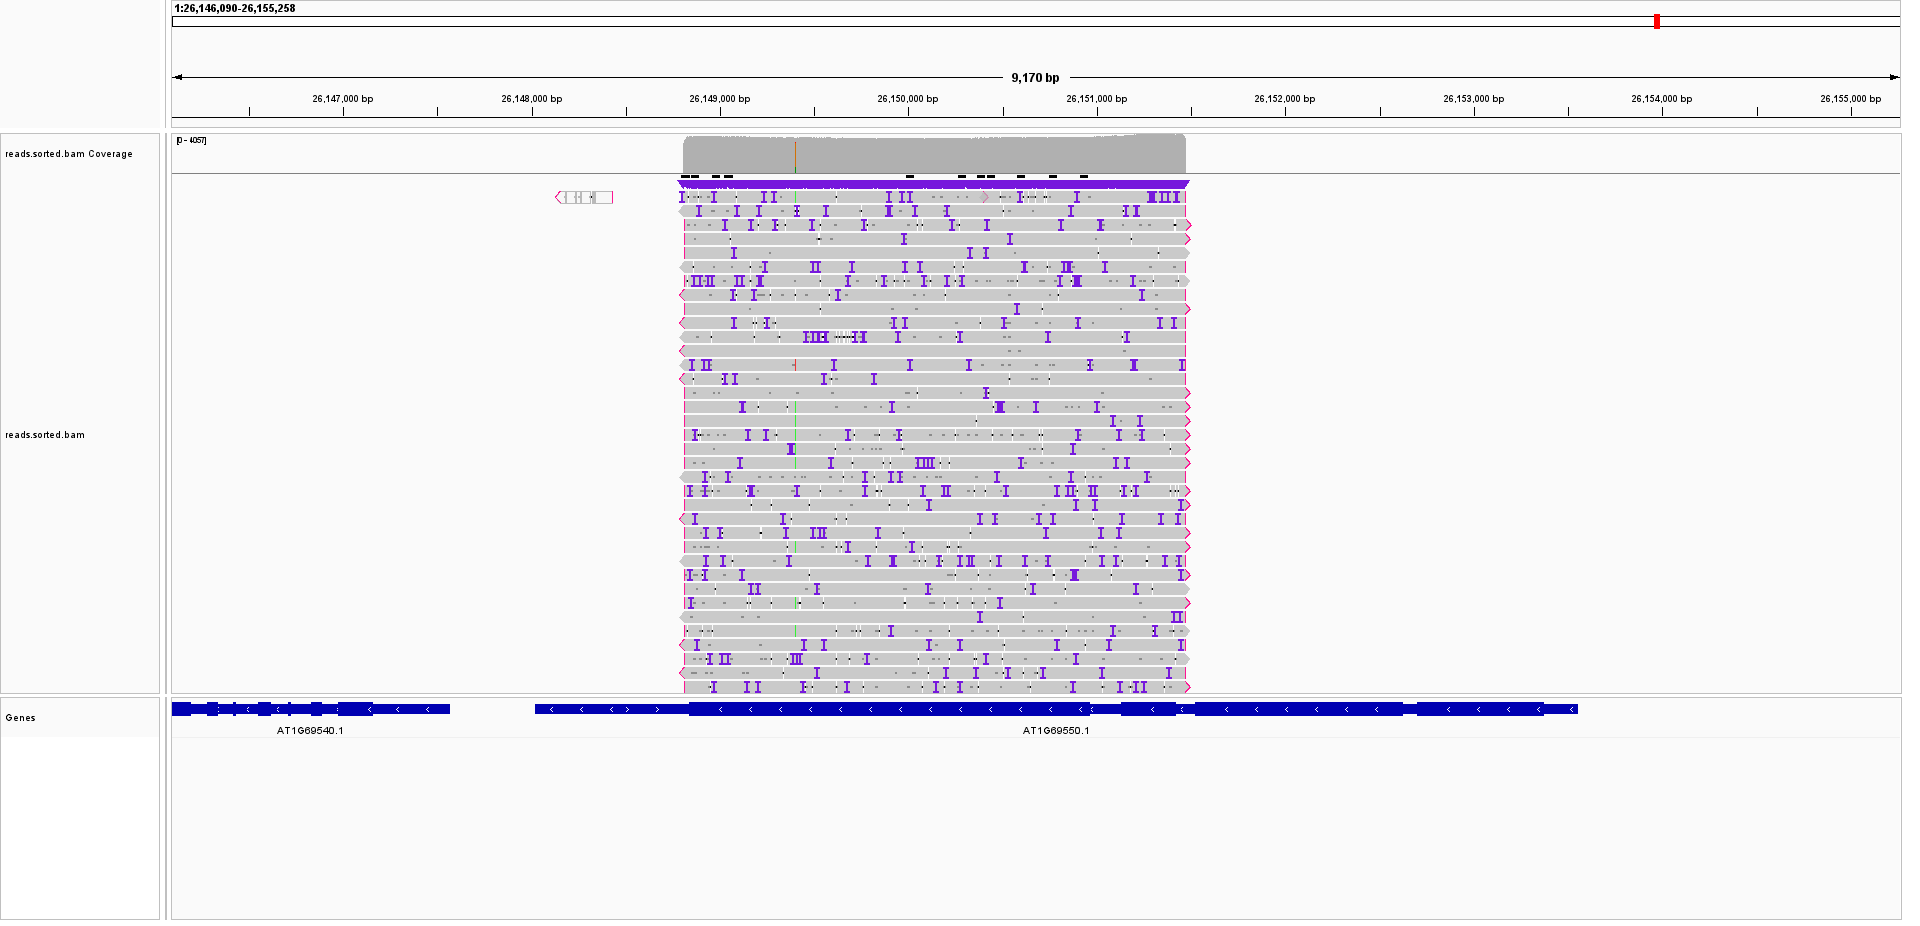

# References

Help installing guppy for colab: https://gist.github.com/sirselim/13f70ae69f2a512e7d9e1f00f9704f53

Google colab inspiration: https://github.com/boxu855/GPHbioinformatics
